<a href="https://colab.research.google.com/github/cholidasofi/deforestation-prediction-analysis/blob/main/deforestation_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

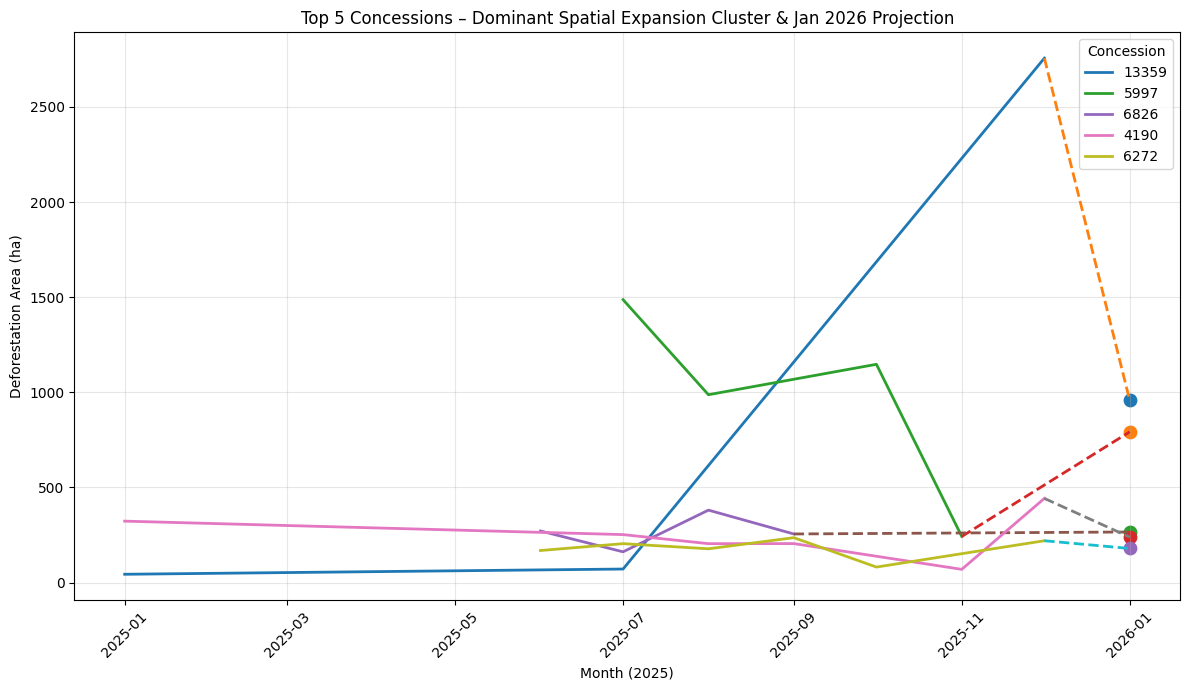

,Concession,Area (ha),rolling_3m_area,expected_jan_2026
35,13359,2756.1885,957.225133,957.225133
115,5997,242.6642,792.515967,792.515967
136,6826,255.7573,266.242100,266.242100
58,4190,442.6603,239.231233,239.231233
127,6272,220.2148,179.447100,179.447100


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cluster import DBSCAN

# 1. Load data
df = pd.read_csv("deforestation_data.csv")
df["Before Date"] = pd.to_datetime(df["Before Date"], errors="coerce")
df["After Date"] = pd.to_datetime(df["After Date"], errors="coerce")

# 2. Month difference

df["months_diff"] = (
    (df["After Date"].dt.year - df["Before Date"].dt.year) * 12 +
    (df["After Date"].dt.month - df["Before Date"].dt.month))

# filer only deforestation in 2025 (<= 3 months gap)
df_filtered = df[
    (df["After Date"].dt.year == 2025) &
    (df["months_diff"] >= 1) &
    (df["months_diff"] <= 3)
].copy()

df_filtered = df_filtered.sort_values(["Concession", "After Date"])

# 4. Spatial clustering per plot

EARTH_RADIUS_KM = 6371
EPS_KM = 5  # cluster radius threshold
EPS_RAD = EPS_KM / EARTH_RADIUS_KM

clustered_data = []

for concession, group in df_filtered.groupby("Concession"):

    if len(group) < 2:
        continue

    coords = np.radians(group[["Lat", "Lon"]].values)

    db = DBSCAN(
        eps=EPS_RAD,
        min_samples=2,
        metric="haversine"
    ).fit(coords)

    group = group.copy()
    group["cluster"] = db.labels_

    # Remove noise points (-1)
    group = group[group["cluster"] != -1]

    if group.empty:
        continue

    # Identify dominant cluster (largest total area)
    dominant_cluster = (
        group.groupby("cluster")["Area (ha)"]
        .sum()
        .idxmax()
    )

    dominant_group = group[group["cluster"] == dominant_cluster]

    clustered_data.append(dominant_group)

# Combine all dominant clusters
df_clustered = pd.concat(clustered_data, ignore_index=True)

# 5. Monthly Aggregate
df_clustered["month"] = (
    df_clustered["After Date"]
    .dt.to_period("M")
    .dt.to_timestamp()
)

monthly = (
    df_clustered.groupby(["Concession", "month"])["Area (ha)"]
    .sum()
    .reset_index()
)

monthly = monthly.sort_values(["Concession", "month"])

# 6. Set 3 months momentum
monthly["rolling_3m_area"] = (
    monthly.groupby("Concession")["Area (ha)"]
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)

monthly["rolling_3m_area"] = monthly["rolling_3m_area"].fillna(
    monthly["Area (ha)"]
)

# 7. Predict January 2026
monthly["expected_jan_2026"] = monthly["rolling_3m_area"]

latest = (
    monthly.sort_values("month")
           .groupby("Concession")
           .tail(1)
)

top5 = (
    latest.sort_values("expected_jan_2026", ascending=False)
          .head(5)
)

top5_concessions = top5["Concession"].tolist()

# 8. Visualization
plt.figure(figsize=(12, 7))

for concession in top5_concessions:

    concession_df = monthly[
        monthly["Concession"] == concession
    ]

    plt.plot(
        concession_df["month"],
        concession_df["Area (ha)"],
        linewidth=2,
        label=f"{concession}"
    )

    last_month = concession_df["month"].max()
    last_area = concession_df.loc[
        concession_df["month"] == last_month,
        "Area (ha)"
    ].values[0]

    predicted_area = concession_df.loc[
        concession_df["month"] == last_month,
        "expected_jan_2026"
    ].values[0]

    jan_2026 = pd.to_datetime("2026-01-01")

    plt.plot(
        [last_month, jan_2026],
        [last_area, predicted_area],
        linestyle="--",
        linewidth=2
    )

    plt.scatter(jan_2026, predicted_area, s=80)

plt.xlabel("Month (2025)")
plt.ylabel("Deforestation Area (ha)")
plt.title("Top 5 Concessions – Dominant Spatial Expansion Cluster & Jan 2026 Projection")
plt.xticks(rotation=45)
plt.legend(title="Concession")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Ranking Table

top5[[
    "Concession",
    "Area (ha)",
    "rolling_3m_area",
    "expected_jan_2026"
]]


Map Visualization



In [2]:
import folium
import numpy as np

# 1. Filter Top 5 plots

top5_concessions = top5["Concession"].tolist()

top5_points = df_clustered[
    df_clustered["Concession"].isin(top5_concessions)
].copy()

prediction_lookup = top5.set_index("Concession")["expected_jan_2026"].to_dict()

top5_points["predicted_area"] = (
    top5_points["Concession"].map(prediction_lookup)
)

# 2. Normalize Bubble Size
min_area = top5_points["predicted_area"].min()
max_area = top5_points["predicted_area"].max()

def normalize(value, min_val, max_val, min_radius=6, max_radius=20):
    if max_val == min_val:
        return 10
    return min_radius + (value - min_val) / (max_val - min_val) * (max_radius - min_radius)

# 3. Create Map

m = folium.Map(tiles="CartoDB positron")

for _, row in top5_points.iterrows():

    radius = normalize(row["predicted_area"], min_area, max_area)

    # Risk category color
    if row["predicted_area"] >= max_area * 0.66:
        risk_label = "High"
        color = "#d73027"
    elif row["predicted_area"] >= max_area * 0.33:
        risk_label = "Medium"
        color = "#fc8d59"
    else:
        risk_label = "Low"
        color = "#1a9850"

    folium.CircleMarker(
        location=[row["Lat"], row["Lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        weight=0
    ).add_to(m)

    # label
    folium.Marker(
        [row["Lat"], row["Lon"]],
        icon=folium.DivIcon(
            html=f"""
                <div style="
                    font-size: 9pt;
                    font-weight: bold;
                    color: black;">
                    {row['Concession']}
                </div>
            """
        )
    ).add_to(m)

# 4. Auto Zoom to Points

bounds = [
    [top5_points["Lat"].min(), top5_points["Lon"].min()],
    [top5_points["Lat"].max(), top5_points["Lon"].max()]
]

m.fit_bounds(bounds)

# 5. Legend
legend_html = """
<div style="
position: fixed;
bottom: 40px; left: 40px; width: 180px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding: 10px;
">

<b>Predicted Risk Level</b><br><br>

<span style="color:#1a9850;">●</span> Low<br>
<span style="color:#fc8d59;">●</span> Medium<br>
<span style="color:#d73027;">●</span> High

</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

m.save("deforestation_risk_map.html")

m

